In [767]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pyart
import xarray as xr

In [768]:
ka1_vads_df #= pd.read_csv('/Users/juliabman/Desktop/research2024/vad_dfs/ka1_vads_df')
ka2_vads_df #= pd.read_csv('/Users/juliabman/Desktop/research2024/vad_dfs/ka2_vads_df')

,index,Datetime,Scantype,Angles,Ranges,Radar,Velmean,Velvar,Bearmean,Latvar,Latmean,Lonvar,Lonmean,tobac_time,tobac_time_indeces,tobac_lats,tobac_lons
0,8,2022-05-23 22:07:37,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2ae1d78e0>,1.347536,14.111219,5.895362,1.871643e+03,33.873137,4.408650e-09,-102.760347,2022-05-23 22:21:17,0,33.725464,-103.115808
1,9,2022-05-23 22:08:09,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a680f640>,0.000000,0.000000,0.350000,0.000000e+00,33.873155,0.000000e+00,-102.760346,2022-05-23 22:21:17,0,33.725464,-103.115808
2,10,2022-05-23 22:08:39,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2b4a7fb20>,0.001304,0.000056,0.350000,0.000000e+00,33.873153,5.418357e-12,-102.760347,2022-05-23 22:21:17,0,33.725464,-103.115808
3,11,2022-05-23 22:09:10,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2ae1d7310>,0.001621,0.000257,0.350000,3.093716e-33,33.873144,6.773982e-12,-102.760346,2022-05-23 22:21:17,0,33.725464,-103.115808
4,12,2022-05-23 22:09:41,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2b4a7f5e0>,0.000217,0.000002,0.350000,0.000000e+00,33.873146,1.675845e-12,-102.760347,2022-05-23 22:21:17,0,33.725464,-103.115808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,221,2022-05-24 01:58:59,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2d2c4ff40>,0.000000,0.000000,99.980000,1.853173e-27,33.587712,0.000000e+00,-102.210940,2022-05-24 02:01:39,37,33.708539,-102.415292
134,222,2022-05-24 01:59:30,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2d2bb05e0>,0.000000,0.000000,99.980000,8.265795e-28,33.587712,0.000000e+00,-102.210942,2022-05-24 02:01:39,37,33.708539,-102.415292
135,223,2022-05-24 02:00:03,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2d2d8d2e0>,0.000000,0.000000,99.980000,0.000000e+00,33.587713,1.235278e-13,-102.210953,2022-05-24 02:01:39,37,33.708539,-102.415292
136,224,2022-05-24 02:00:33,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2d2d8de50>,0.000000,0.000000,99.980000,2.043243e-28,33.587713,3.406293e-14,-102.210950,2022-05-24 02:01:39,37,33.708539,-102.415292


In [769]:
ka1_vads_radar = np.array(ka1_vads_df.Radar)

In [770]:
refl_dbz_list = []
for radar in range(len(ka1_vads_radar)):
    reflectivity = ka1_vads_radar[radar].fields['reflectivity']['data']
    refl_dbz_list.append(reflectivity)

In [771]:
vel_list = []
for radar in range(len(ka1_vads_radar)):
    vel = ka1_vads_radar[radar].fields['velocity']['data']
    vel_list.append(vel)

In [766]:
# At this point, we can simply used dealias_region_based to dealias the velocities
# and then add the new field to the radar.
for radar in ka1_vads_radar:
    print(radar)
    vel_texture = pyart.retrieve.calculate_velocity_texture(
    radar, vel_field="velocity", wind_size=2, nyq=31.875
    )
    # Set up the gatefilter to be based on the velocity texture.
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_above("velocity_texture", 2)
    radar.add_field("velocity_texture", vel_texture, replace_existing=True)

    nyq = radar.instrument_parameters["nyquist_velocity"]["data"][0]
    velocity_dealiased = pyart.correct.dealias_region_based(
        radar, vel_field="velocity", nyquist_vel=nyq, centered=True, gatefilter=gatefilter
    )
    radar.add_field("dealiased_velocity", velocity_dealiased, replace_existing=True)

/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/pyart/util/sigmath.py:63: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/pyart/util/sigmath.py:63: RuntimeWarning: divide by zero encountered in log
  std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi


KeyboardInterrupt: 

In [772]:
# Vt = terminal fall velocity
# values of a and b are taken from papers: "Seasonal controls on isolated convective storm drafts,
# precipitation intensity, and life cycle as observed during GoAmazon2014/5" pg 5299
# Z = reflectivity from VAD
# Ze = equivalent reflectivity
Vt_list = []
for Z in refl_dbz_list:
    a = 2.7
    b = 0.1
    #print(Z)
    Ze = np.power(10, Z/10) # log equation
    Vt = a * (Ze ** b)
    Vt_list.append(Vt)

In [773]:
# for now just assumed the terminal fall velocity vector is straight down, ie 90 degrees to the ground
radar_sensed_terminal_list = []
for Vt in Vt_list:
    theta = 37
    theta_radians = np.radians(theta)
    radar_sensed_terminal = sin(theta_radians) * Vt
    radar_sensed_terminal_list.append(radar_sensed_terminal)

In [774]:
dealiased_vel_list = []
for radar in ka1_vads_radar:
    vel = radar.fields['dealiased_velocity']['data']
    dealiased_vel_list.append(vel)

In [788]:
dealiased_vel_list[125].data

array([[ 0.0000000e+00, -2.5098425e-01,  0.0000000e+00, ...,
        -9.9990000e+03, -9.9990000e+03, -7.5295275e-01],
       [ 0.0000000e+00, -2.5098425e-01,  0.0000000e+00, ...,
        -9.9990000e+03, -9.9990000e+03, -7.5295275e-01],
       [ 0.0000000e+00, -2.5098425e-01,  0.0000000e+00, ...,
        -9.9990000e+03, -9.9990000e+03, -7.5295275e-01],
       ...,
       [ 0.0000000e+00, -2.5098425e-01,  0.0000000e+00, ...,
        -9.9990000e+03, -9.9990000e+03, -7.5295275e-01],
       [ 0.0000000e+00, -2.5098425e-01,  0.0000000e+00, ...,
        -9.9990000e+03, -9.9990000e+03, -7.5295275e-01],
       [ 0.0000000e+00, -2.5098425e-01,  0.0000000e+00, ...,
        -9.9990000e+03, -9.9990000e+03, -7.5295275e-01]], dtype=float32)

In [789]:
dealiased_vel_list[125].data.max()

41.161415

In [825]:
new_da_vel_list = []
for i in range(len(vel_list)):
    #print(vel_list[i].data)
    #print(radar_sensed_terminal_list[i].data)
    new_vel = dealiased_vel_list[i].data + radar_sensed_terminal_list[i].data
    new_da_vel_list.append(new_vel)

In [792]:
new_da_vel_list[125].max()

43.404404

In [776]:
test_radar_dealiased = ka1_vads_radar[125]

In [812]:
corr_vel = {
    "data": new_da_vel_list[125],
    "units": "meters_per_second",
    "long_name": "corrected_velocity_terminal_redo",
    "_FillValue": -9999.0,
    "standard_name": "corrected_velocity_terminal_redo",
}

In [814]:
corr_vel_radar = test_radar.add_field('corrected_velocity_terminal_redo', corr_vel, replace_existing = True)

In [802]:
new_da_vel_list[125].shape

(2046, 555)

In [840]:
corr = corr_vel['data'] - dealiased_vel_list[125]

/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/pyart/graph/radarmapdisplay.py:317: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Lambert Conformal.
  warnings.warn(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3

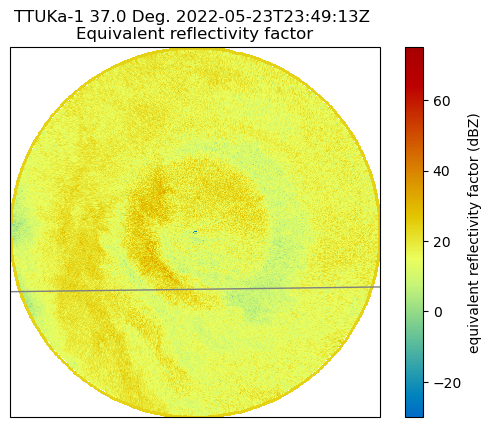

In [778]:
radar_map_display = pyart.graph.RadarMapDisplay(test_radar)
radar_map_display.plot_ppi_map('reflectivity')

/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/pyart/graph/radarmapdisplay.py:317: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Lambert Conformal.
  warnings.warn(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3

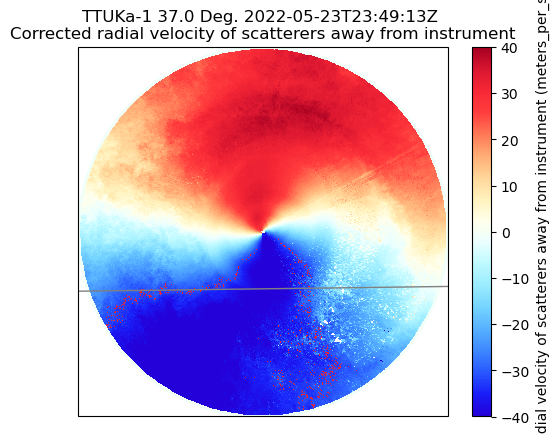

In [779]:
radar_map_display = pyart.graph.RadarMapDisplay(test_radar)
radar_map_display.plot_ppi_map('corrected_velocity', cmap = 'pyart_BuDRd18', vmin = -40, vmax = 40)

/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/pyart/graph/radarmapdisplay.py:317: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Lambert Conformal.
  warnings.warn(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3

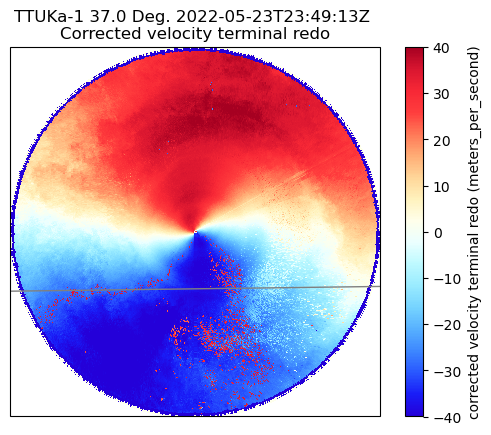

In [826]:
radar_map_display = pyart.graph.RadarMapDisplay(test_radar)
radar_map_display.plot_ppi_map('corrected_velocity_terminal_redo', cmap = 'pyart_BuDRd18', vmin = -40, vmax = 40)

In [841]:
corr_vel2 = {
    "data": corr,
    "units": "meters_per_second",
    "long_name": "difference_of_corr_vel_and_original_vel",
    "_FillValue": -9999.0,
    "standard_name": "corrected_difference",
}

In [842]:
corr_vel_radar2 = test_radar.add_field('corrected_difference', corr_vel2, replace_existing = True)

/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/pyart/graph/radarmapdisplay.py:317: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Lambert Conformal.
  warnings.warn(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/juliabman/miniforge3/envs/Research/lib/python3

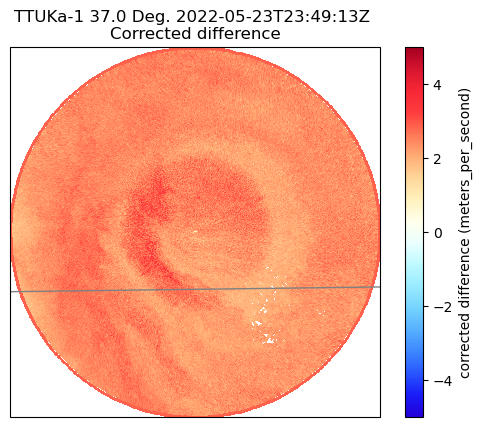

In [844]:
radar_map_display = pyart.graph.RadarMapDisplay(test_radar)
radar_map_display.plot_ppi_map('corrected_difference', cmap = 'pyart_BuDRd18', vmin = -5, vmax = 5)